# Image Classification with CNN

In [1]:
import pandas as pd
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import tensorflow as tf
import os

from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from skimage import io, transform

from keras.metrics import AUC
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

2023-03-25 20:32:29.437816: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-25 20:32:29.471690: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-25 20:32:29.472170: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 20:32:29.972334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_history(history, title = ''):
  plt.ylabel('AUC')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['auc_4'], label="training", marker='o')
  plt.plot(history['val_auc_4'], label="validation", marker='o')
  plt.title(title)
  plt.legend()
  plt.show()

## Settings

In [3]:
dicom_directory = f'../train_images'

In [4]:
random_state = 42

In [5]:
random.seed(random_state)
tf.random.set_seed(random_state)
np.random.seed(random_state)

In [6]:
# dimensions to resize
resize_dimensions = (224, 224)

In [7]:
USE_IMPORTED_DATA = False
USE_REDUCED_DATASET = True

## Import Data

In [8]:
# Took about 50 minutes

if not os.path.isfile('image_metrics.csv') and not USE_IMPORTED_DATA:
    # Create an empty list to store file names and metadata
    dicom_files = []

    image_path_list = glob(f'{dicom_directory}/*/*.dcm')

    for image_path in tqdm(image_path_list, total=len(image_path_list)):
        filename = image_path.split('/')[-1]
        
        ds = pydicom.dcmread(image_path)
#         samp_per_pix = ds.SamplesPerPixel
        n_rows_image = ds.Rows
        n_cols_image = ds.Columns
        dicom_files.append([filename, n_rows_image, n_cols_image, image_path])

    # Create a Pandas DataFrame from the list
    image_metrics_df = pd.DataFrame(dicom_files, columns=["filename", "n_rows", "n_cols", "file_path"])

    output_file = "image_metrics.csv"
    image_metrics_df.to_csv(output_file, index=False)
else:
    image_metrics_df = pd.read_csv('image_metrics.csv')

image_metrics_df.head()

,filename,n_rows,n_cols,file_path
0,1459541791.dcm,5355,4915,../train_images/10006/1459541791.dcm
1,1864590858.dcm,5355,4915,../train_images/10006/1864590858.dcm
2,1874946579.dcm,5355,4915,../train_images/10006/1874946579.dcm
3,462822612.dcm,5355,4915,../train_images/10006/462822612.dcm
4,1031443799.dcm,2776,2082,../train_images/10011/1031443799.dcm


In [9]:
counts_df = image_metrics_df.groupby(['n_rows', 'n_cols'])['filename'].size().reset_index().rename(columns = {'filename': 'counts'})
counts_df.sort_values(by='counts', ascending=False)

,n_rows,n_cols,counts
7,4096,3328,24109
6,3328,2560,9042
9,5355,4915,8267
3,2776,2082,8221
1,2294,1914,2703
5,3062,2394,1276
8,4740,3540,732
10,5928,4728,338
4,2850,2394,13
2,2473,2045,3


### Get most common image dimensions

In [26]:
# Most common image dimensions
rows = 4096
cols = 3328 

selected_dimensions_df = image_metrics_df[
    (image_metrics_df['n_rows'] == rows) &
    (image_metrics_df['n_cols'] == cols)
]
selected_images = list(selected_dimensions_df['filename'])

In [43]:
metadata_df = pd.read_csv(r"../train.csv")
cancer_map = {f"{str(rows['image_id'])}.dcm": rows['cancer'] for i, rows in metadata_df.iterrows()}

In [53]:
# get selected images
df = image_metrics_df.loc[image_metrics_df['filename'].isin(selected_images), :]

# add cancer labels
df['cancer'] = df['filename'].map(cancer_map)

if USE_REDUCED_DATASET:
    df = df.sample(3000, random_state=random_state)
    print(f'Number of samples: {len(df)}')

df.head()

Number of samples: 3000


/tmp/ipykernel_374/250811325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cancer'] = df['filename'].map(cancer_map)


,filename,n_rows,n_cols,file_path,cancer
53865,164691998.dcm,4096,3328,../train_images/9052/164691998.dcm,0
25494,1253463023.dcm,4096,3328,../train_images/37265/1253463023.dcm,0
51188,457120714.dcm,4096,3328,../train_images/65181/457120714.dcm,0
19212,1721323862.dcm,4096,3328,../train_images/30319/1721323862.dcm,0
445,65932486.dcm,4096,3328,../train_images/1045/65932486.dcm,0


### Split Data into Training and Test

In [16]:
# Resizing using skimage.transform
# Resizing 2400 training images took 54:09
# Resizing 600 test images took 13:39

# TODO: Maybe try tf.image.resize?
# TODO: Parallelizing

In [282]:
name_tag = ''
if USE_REDUCED_DATASET:
    reduced_tag = '_reduced'
    
if not USE_IMPORTED_DATA and not os.path.isfile(f'X_train{reduced_tag}.pickle') and not os.path.isfile(f'X_test{reduced_tag}.pickle'):
    train_df, test_df, y_train, y_test = train_test_split(df[['filename', 'file_path']], df['cancer'], test_size=0.2, random_state=random_state)
    
    y_train.to_csv(f'y_train{reduced_tag}.csv')
    y_test.to_csv(f'y_test{reduced_tag}.csv')
    
    
    # RESIZE IMAGES
    print('Resizing Train images')
    images_train = []
    for i, rows in tqdm(train_df.reset_index(drop=True).iterrows(), total=len(train_df)):
        ds = pydicom.dcmread(rows['file_path'])
        images_train.append(transform.resize(ds.pixel_array, resize_dimensions))
    
    print('Resizing Test images')
    images_test = []
    for i, rows in tqdm(test_df.reset_index(drop=True).iterrows(), total=len(test_df)):
        ds = pydicom.dcmread(rows['file_path'])
        images_test.append(transform.resize(ds.pixel_array, resize_dimensions))
    
    X_train = np.array(images_train)
    X_test = np.array(images_test)
    
    
    with open(f'X_train{reduced_tag}.pickle', 'wb') as f:
        pickle.dump(X_train, f)
    with open(f'X_test{reduced_tag}.pickle', 'wb') as f:
        pickle.dump(X_test, f)
    
else:
    y_train = pd.read_csv(f'y_train{reduced_tag}.csv', index_col=0)
    y_test = pd.read_csv(f'y_test{reduced_tag}.csv', index_col=0)
  

    with open(f'X_train{reduced_tag}.pickle', 'rb') as f:
        X_train = pickle.load(f)
        
    with open(f'X_test{reduced_tag}.pickle', 'rb') as f:
        X_test = pickle.load(f)


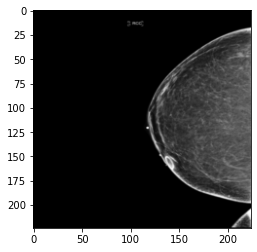

In [283]:
plt.imshow(X_train[0], cmap=plt.cm.gray)
plt.show()

In [284]:
print('Train label counts')
print(y_train['cancer'].value_counts())
print('\n')
print('Test label counts')
print(y_test['cancer'].value_counts())

Train label counts
0    2355
1      45
Name: cancer, dtype: int64


Test label counts
0    580
1     20
Name: cancer, dtype: int64


In [285]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (2400, 224, 224)
X_test shape: (600, 224, 224)


In [286]:
X_train, X_val, y_train, y_val = train_test_split(X_train, np.array(y_train).flatten(), test_size=0.2)

In [279]:
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')

X_train shape: (3016, 224, 224, 1)
X_val shape: (755, 224, 224, 1)


## EDA

## Preprocess Data

In [295]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [296]:
majority_data = X_train[np.where(y_train == 0)[0]]
minority_data = X_train[np.where(y_train == 1)[0]]

print(f'Majority size: {len(majority_data)}')
print(f'Minority size: {len(minority_data)}')

Majority size: 1884
Minority size: 36


In [244]:
datagen = ImageDataGenerator(
    rotation_range=10,  # augmentations
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)


minority_generator = datagen.flow(
    minority_data,
    np.ones(len(minority_data)),
    batch_size=1,
    seed=random_state
)

In [ ]:
# adding augmented images runtime: 

In [245]:
# num_images_to_add = len(majority_data) - len(minority_data) - 1

# for i, (x, y) in tqdm(enumerate(minority_generator), total=num_images_to_add):
#     X_train = np.vstack([X_train, x[0].reshape((1, resize_dimensions[0], resize_dimensions[1], 1))])
#     y_train = np.append(y_train, y[0])
    
#     if i == num_images_to_add:
#         break
# #     plt.imshow(testing[0][0], cmap=plt.cm.gray)
# #     plt.show()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1850/1850 [05:59<00:00,  5.15it/s]


In [253]:
# majority_data = X_train[np.where(y_train == 0)[0]]
# minority_data = X_train[np.where(y_train == 1)[0]]

# print(f'Majority size: {len(majority_data)}')
# print(f'Minority size: {len(minority_data)}')

Majority size: 1885
Minority size: 1886


In [287]:
type(X_train)

numpy.ndarray

In [293]:
type(y_train)

numpy.ndarray

In [297]:
X_train.shape

(1920, 224, 224, 1)

In [298]:
y_train.shape

(1920,)

## Build Model

In [299]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, 224, 224, 1))
model.summary()



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 26, 26, 128)     

In [300]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[AUC()])


In [301]:
epochs = 10
cnn = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=epochs,
    validation_data=val_dataset
)

Epoch 1/10
60/60 [==============================] - ETA: 0s - loss: 0.1583 - auc_8: 0.5204

2023-03-25 23:34:25.012094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-03-25 23:34:25.211100: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at segment_reduction_ops_impl.h:476 : INVALID_ARGUMENT: data.shape = [2] does not start with segment_ids.shape = [1]
2023-03-25 23:34:25.211196: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: data.shape = [2] does not start with segment_ids.shape = [1]
	 [[{{node UnsortedSegmentSum_1}}]]
2023-03-25 23:34:25.211213: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at segment_reduction_ops

InvalidArgumentError: Graph execution error:

Detected at node 'UnsortedSegmentSum_1' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_374/2809430666.py", line 2, in <module>
      cnn = model.fit(
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1729, in fit
      val_logs = self.evaluate(
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2072, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1852, in test_function
      return step_function(self, iterator)
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1836, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1824, in run_step
      outputs = model.test_step(data)
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1791, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1149, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/metrics/confusion_metrics.py", line 1485, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 684, in update_confusion_matrix_variables
      return _update_confusion_matrix_variables_optimized(
    File "/home/bho597/.local/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 473, in _update_confusion_matrix_variables_optimized
      fp_bucket_v = tf.math.unsorted_segment_sum(
Node: 'UnsortedSegmentSum_1'
data.shape = [2] does not start with segment_ids.shape = [1]
	 [[{{node UnsortedSegmentSum_1}}]] [Op:__inference_test_function_17803]

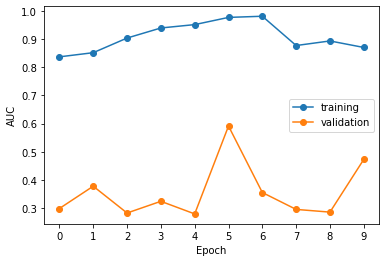

In [113]:
history = pd.DataFrame(cnn.history)
# history
plot_history(history)